## BVerfG Datenanalyse 💻

Dieses Notebook wertet den Korpus an Entscheidungen und Urteilen des BVerfG aus, der zugänglich unter https://zenodo.org/records/12705674 "CE-BVerfG_2024-07-24_DE_CSV_Datensatz.zip" ist.

Der Korpus beinhaltet dabei eine Sammlung aller Entscheidungen, die vollständig in ihrer Natur sind. Es handelt sich dabei um eine Sammlung von ca. 9000 Urteilen, von 1951 bis 2024. 

In [1]:
# Separate Downloads, die einmalig getätigt werden sollten
# SpaCy
# pip install -U pip setuptools wheel
# pip install -U spacy
# python -m spacy download de_core_news_sm

In [2]:
# Import packages
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import numpy as np

# Text analysis
import re
import nltk 

## 1.0 Data Preparation
Hier wird der Datensatz zum ersten Mal eingelesen und erste Abbildungen für ein erstes Erkunden des Datensatzes erstellt.

In [3]:
df = pd.read_csv("data/CE-BVerfG_2024_Datensatz.csv")
print(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8949 entries, 0 to 8948
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   doc_id             8949 non-null   object 
 1   text               8949 non-null   object 
 2   url_html           8949 non-null   object 
 3   url_pdf            8949 non-null   object 
 4   gericht            8949 non-null   object 
 5   datum              8949 non-null   object 
 6   entscheidungsjahr  8949 non-null   int64  
 7   entscheidung_typ   8949 non-null   object 
 8   spruchkoerper_typ  8949 non-null   object 
 9   spruchkoerper_az   8939 non-null   float64
 10  registerzeichen    8949 non-null   object 
 11  verfahrensart      8949 non-null   object 
 12  eingangsnummer     8949 non-null   int64  
 13  eingangsjahr_az    8949 non-null   int64  
 14  eingangsjahr_iso   8949 non-null   int64  
 15  kollision          44 non-null     object 
 16  name               921 n

,doc_id,text,url_html,url_pdf,gericht,datum,entscheidungsjahr,entscheidung_typ,spruchkoerper_typ,spruchkoerper_az,...,v_praesi,richter,zeichen,tokens,typen,saetze,version,doi_concept,doi_version,lizenz
0,BVerfG_1951-09-09_S_2_BvQ_0001_51_NA_Südwestst...,BUNDESVERFASSUNGSGERICHT\n\n- 2 BvQ 1/51 -\n\n...,https://www.bundesverfassungsgericht.de/Shared...,https://www.bundesverfassungsgericht.de/Shared...,BVerfG,1951-09-09,1951,B,S,2.0,...,Katz,Dr. Katz|Dr. Fröhlich|Wolff|Dr. Roediger|Dr. K...,5869,759,324,61,2024-07-24,10.5281/zenodo.3902658,10.5281/zenodo.12705674,Creative Commons Zero 1.0 Universal (CC Zero 1.0)
1,BVerfG_1952-09-10_S_1_BvR_0379_52_NA_Fristlauf...,Leitsätze\n\n zum ...,https://www.bundesverfassungsgericht.de/Shared...,https://www.bundesverfassungsgericht.de/Shared...,BVerfG,1952-09-10,1952,B,S,1.0,...,Katz,Dr. Dr.|Höpker-Aschoff|Ellinghaus|Dr. Scheffle...,7489,1074,411,81,2024-07-24,10.5281/zenodo.3902658,10.5281/zenodo.12705674,Creative Commons Zero 1.0 Universal (CC Zero 1.0)
2,BVerfG_1952-10-10_S_1_BvR_0511_52_NA_BGH-Straf...,Leitsätze\n\n\n zu...,https://www.bundesverfassungsgericht.de/Shared...,https://www.bundesverfassungsgericht.de/Shared...,BVerfG,1952-10-10,1952,B,S,1.0,...,Katz,Dr. Dr.|Höpker-Aschoff|Ellinghaus|Dr. Heiland|...,5061,706,283,57,2024-07-24,10.5281/zenodo.3902658,10.5281/zenodo.12705674,Creative Commons Zero 1.0 Universal (CC Zero 1.0)


In [4]:
# Null values
df.isna().sum()[df.isna().sum() > 0]

spruchkoerper_az       10
kollision            8905
name                 8028
band                 8028
seite                8028
aktenzeichen_alle       7
kurzbeschreibung      397
pressemitteilung     6870
richter                24
dtype: int64

### 1.1 Cleanup 🫧
Der Datensatz wird im folgenden Teil für die weitere Verarbeitung aufbereitet und gereinigt.

In [5]:
# Richter maybe to use later on... TODO
df_richter = df["richter"].str.split('|', expand=True)

df_richter = df_richter.replace("Dr. Dr.", None).dropna(axis=1, how="all")

df_richter.columns = [f"richter_{i+1}" for i in range(df_richter.shape[1])]

df = df.join(df_richter)

In [6]:
df.columns

Index(['doc_id', 'text', 'url_html', 'url_pdf', 'gericht', 'datum',
       'entscheidungsjahr', 'entscheidung_typ', 'spruchkoerper_typ',
       'spruchkoerper_az', 'registerzeichen', 'verfahrensart',
       'eingangsnummer', 'eingangsjahr_az', 'eingangsjahr_iso', 'kollision',
       'name', 'bverfge', 'band', 'seite', 'aktenzeichen', 'aktenzeichen_alle',
       'ecli', 'zitiervorschlag', 'kurzbeschreibung', 'pressemitteilung',
       'praesi', 'v_praesi', 'richter', 'zeichen', 'tokens', 'typen', 'saetze',
       'version', 'doi_concept', 'doi_version', 'lizenz', 'richter_1',
       'richter_2', 'richter_3', 'richter_4', 'richter_5', 'richter_6',
       'richter_7', 'richter_8', 'richter_9', 'richter_10', 'richter_11',
       'richter_12', 'richter_13', 'richter_14', 'richter_15', 'richter_16'],
      dtype='object')

In [7]:
# Folgende Features können verworfen werden:
df_drop = df.drop([
    'gericht', 'url_pdf',
    'verfahrensart', # Registerzeichen nur ausgeschrieben
       'eingangsnummer', 'eingangsjahr_az', 'eingangsjahr_iso',
         'kollision', # Könnte eventuell noch interessant TODO check?
    'name', 'bverfge', 'band', 'seite', 'aktenzeichen', 'aktenzeichen_alle',
       'ecli', 'zitiervorschlag', 'kurzbeschreibung', 
       #'pressemitteilung',
       'praesi', 'v_praesi', 'richter',
       'version', 'doi_concept', 'doi_version', 'lizenz'
                   ], axis=1) 

In [8]:
print("Null values:")
print(df_drop.isna().sum()[df_drop.isna().sum() > 0],"\n")
print("Data types:")
print(df_drop.dtypes)

Null values:
spruchkoerper_az      10
pressemitteilung    6870
richter_1             26
richter_2             29
richter_3             31
richter_4           7446
richter_5           7458
richter_6           7460
richter_7           7498
richter_8           7760
richter_9           8910
richter_10          8917
richter_11          8926
richter_12          8943
richter_13          8944
richter_14          8947
richter_15          8947
richter_16          8948
dtype: int64 

Data types:
doc_id                object
text                  object
url_html              object
datum                 object
entscheidungsjahr      int64
entscheidung_typ      object
spruchkoerper_typ     object
spruchkoerper_az     float64
registerzeichen       object
pressemitteilung      object
zeichen                int64
tokens                 int64
typen                  int64
saetze                 int64
richter_1             object
richter_2             object
richter_3             object
richter_4        

In [2]:
############ TODO: daten vergleichen ?? Datum nicht korrekt ausgelesen?

In [9]:
# Ändere den Datentyp von Datum zu datetime
df_drop["datum"] = pd.to_datetime(df_drop["datum"])
df_drop["entscheidungsjahr"] = df_drop["datum"].dt.year

In [10]:
# spruchkoerper_az ist entweder 1 oder 2; NaN-values sind "Verzögerungsbeschwerden"
# NaN-Values werden mit 0 für Vereinfachung von Processing markiert
df_drop["spruchkoerper_az"] = df_drop["spruchkoerper_az"].fillna(0)

# Zusätzliches Umwandeln von float zu int
df_drop["spruchkoerper_az"] = df_drop["spruchkoerper_az"].astype(int)

In [11]:
print("Null values:")
print(df_drop.isna().sum()[df_drop.isna().sum() > 0],"\n")
print("Data types:")
print(df_drop.dtypes)

Null values:
pressemitteilung    6870
richter_1             26
richter_2             29
richter_3             31
richter_4           7446
richter_5           7458
richter_6           7460
richter_7           7498
richter_8           7760
richter_9           8910
richter_10          8917
richter_11          8926
richter_12          8943
richter_13          8944
richter_14          8947
richter_15          8947
richter_16          8948
dtype: int64 

Data types:
doc_id                       object
text                         object
url_html                     object
datum                datetime64[ns]
entscheidungsjahr             int32
entscheidung_typ             object
spruchkoerper_typ            object
spruchkoerper_az              int32
registerzeichen              object
pressemitteilung             object
zeichen                       int64
tokens                        int64
typen                         int64
saetze                        int64
richter_1                    ob

In [12]:
# Check welche Entscheidungen aus welchen Jahren im Datensatz vorhanden sind, und wie viele vorliegen
print(df_drop["entscheidungsjahr"].unique())
df_drop[["doc_id","entscheidungsjahr"]].groupby("entscheidungsjahr").agg("count").reset_index()

[1951 1952 1957 1958 1959 1973 1977 1983 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


,entscheidungsjahr,doc_id
0,1951,1
1,1952,2
2,1957,1
3,1958,1
4,1959,1
5,1973,1
6,1977,1
7,1983,2
8,1991,1
9,1992,22


In [13]:
print("Ältester Eintrag: ", df_drop["datum"].min())
print("Neuster Eintrag: ", df_drop["datum"].max())


Ältester Eintrag:  1951-09-09 00:00:00
Neuster Eintrag:  2024-07-02 00:00:00


Der Datensatz bildet ein teilweise vollständiges Abbild aller Entscheidungen ab. Allerdings sind laut Autor nur vollständige Entscheidungen aufgenommen worden, und damit auch solche die über die eigene Webseite des BVerfG auch verfügbar sind (sowohl als .html als auch .pdf). 

Dies ist nur ein kleiner Ausschnitt an Entscheidungen. Seit Gründung des BVerfG 1951, sind schätzungsweise 245.000 Verfassungsbeschwerden eingegangen. Da diese allerdings nicht frei zugänglich sind, und dies ein Scraping ausschließt, wird sich lediglich auf die ca. 9000 vollständingen Entscheidungen beschränkt.  

### 1.2 Exploratory Data Analysis (EDA) 🩻
Erste Abbildungen über den Datensatz um interessante Strukturen möglicherweise hervorzuheben, und möglicherweise weitere Clean-up Möglichkeiten aufzudecken.

Text(0.5, 1.0, 'Anzahl an Entscheidungen nach Verfahrensart')

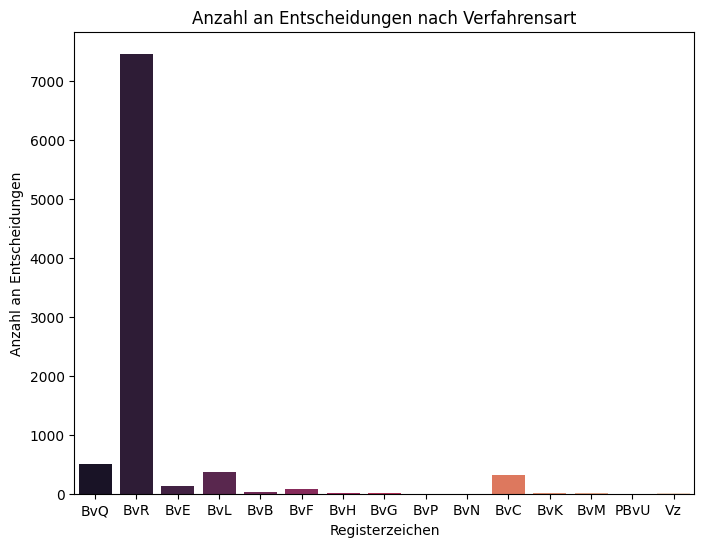

In [14]:
fig = plt.figure(figsize=(8,6))
sns.countplot(df_drop, x="registerzeichen", hue="registerzeichen", palette="rocket", legend=False)
plt.xlabel("Registerzeichen")
plt.ylabel("Anzahl an Entscheidungen")
plt.title("Anzahl an Entscheidungen nach Verfahrensart")

In [15]:
df_drop.columns

Index(['doc_id', 'text', 'url_html', 'datum', 'entscheidungsjahr',
       'entscheidung_typ', 'spruchkoerper_typ', 'spruchkoerper_az',
       'registerzeichen', 'pressemitteilung', 'zeichen', 'tokens', 'typen',
       'saetze', 'richter_1', 'richter_2', 'richter_3', 'richter_4',
       'richter_5', 'richter_6', 'richter_7', 'richter_8', 'richter_9',
       'richter_10', 'richter_11', 'richter_12', 'richter_13', 'richter_14',
       'richter_15', 'richter_16'],
      dtype='object')

Text(0.5, 1.0, 'Anzahl an Entscheidungen nach Sprüchkörper-Typen')

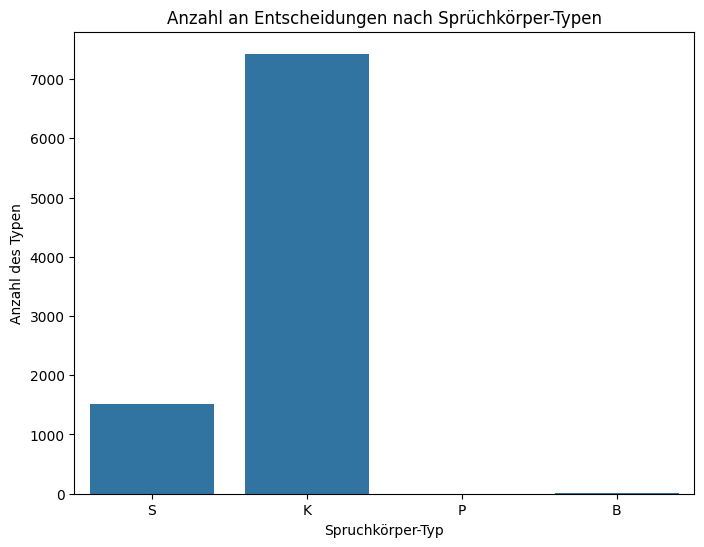

In [16]:
fig = plt.figure(figsize=(8,6))
sns.countplot(df_drop, x="spruchkoerper_typ")
plt.xlabel("Spruchkörper-Typ")
plt.ylabel("Anzahl des Typen")
plt.title("Anzahl an Entscheidungen nach Sprüchkörper-Typen")

In [17]:
print("Anzahl an P-Entscheidungen: ",df_drop[df_drop["spruchkoerper_typ"] == "P"].shape[0])
print("Anzahl an B-Entscheidungen: ",df_drop[df_drop["spruchkoerper_typ"] == "B"].shape[0])

Anzahl an P-Entscheidungen:  2
Anzahl an B-Entscheidungen:  10


Text(0.5, 1.0, 'Entscheidungen pro Jahr')

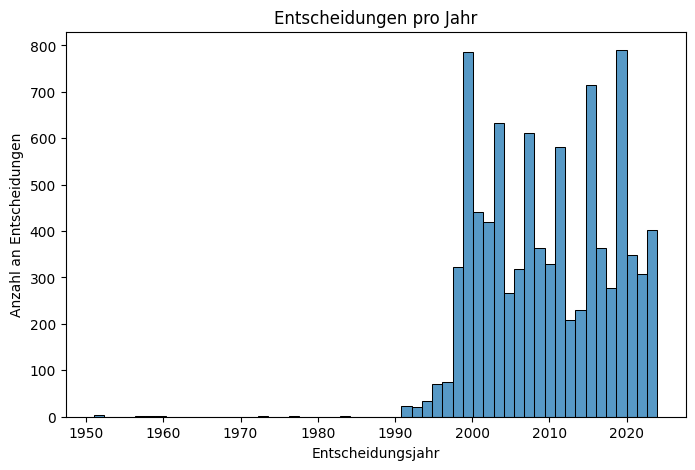

In [18]:
# Plot mit Entscheidungne pro Jahr
fig = plt.figure(figsize=(8,5))
sns.histplot(df_drop, x="entscheidungsjahr")
plt.xlabel("Entscheidungsjahr")
plt.ylabel("Anzahl an Entscheidungen")
plt.title("Entscheidungen pro Jahr")

Diese Abbildung ist nicht so aussagend, vor dem Hintegrund dass es sich hierbei um vollständige Entscheidungen handelt, nicht alle möglichen, die in dem Jahr auch tatsächlich getätigt worden sind.

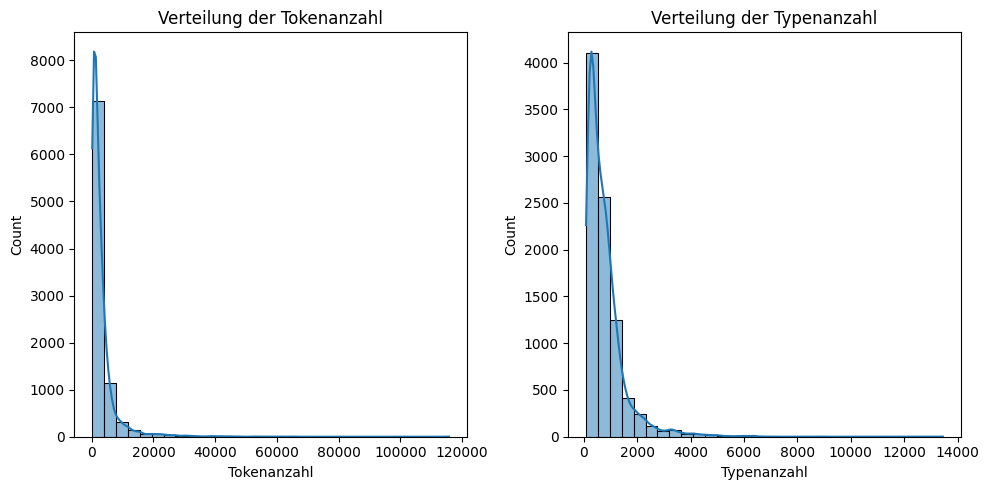

In [19]:
# Histogram for tokens and types
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(df_drop["tokens"], bins=30, kde=True, ax=axs[0])
axs[0].set_xlabel("Tokenanzahl")
axs[0].set_title("Verteilung der Tokenanzahl")

sns.histplot(df_drop["typen"], bins=30, kde=True, ax=axs[1])
axs[1].set_xlabel("Typenanzahl")
axs[1].set_title("Verteilung der Typenanzahl")

plt.tight_layout()
plt.show()


Hier sind insbesondere die Wörter innerhalb des "Ellbogens" der Kurve interessant. Für die späteren gefilterten Relgions-präsenten Datensätze interessant noch einmal durchzuführen!. TODO

In [20]:
def compute_sttr(text, window_size=1000):
    words = nltk.word_tokenize(text) 
    if len(words) < window_size:
        return len(set(words)) / len(words) if words else 0

    num_windows = len(words) // window_size
    ttr_values = np.array([
        len(set(words[i * window_size : (i + 1) * window_size])) / window_size
        for i in range(num_windows)
    ])

    return np.mean(ttr_values) if ttr_values.size > 0 else 0

In [21]:
# Get TTR 
df_drop["TTR"] = df_drop["typen"] / df_drop["tokens"]

Text(0, 0.5, 'TTR')

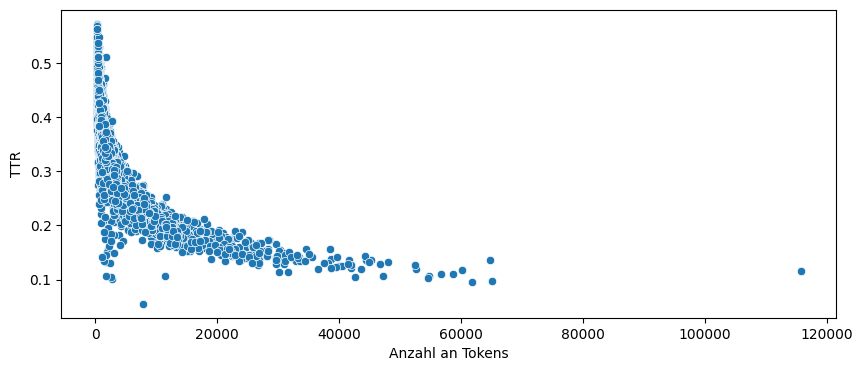

In [22]:
# TTR plotted
plt.figure(figsize=(10, 4))

sns.scatterplot(data=df_drop, x="tokens", y="TTR")
plt.xlabel("Anzahl an Tokens")
plt.ylabel("TTR")

In [23]:
# Get STTR
df_drop["STTR"] = df_drop["text"].apply(compute_sttr)

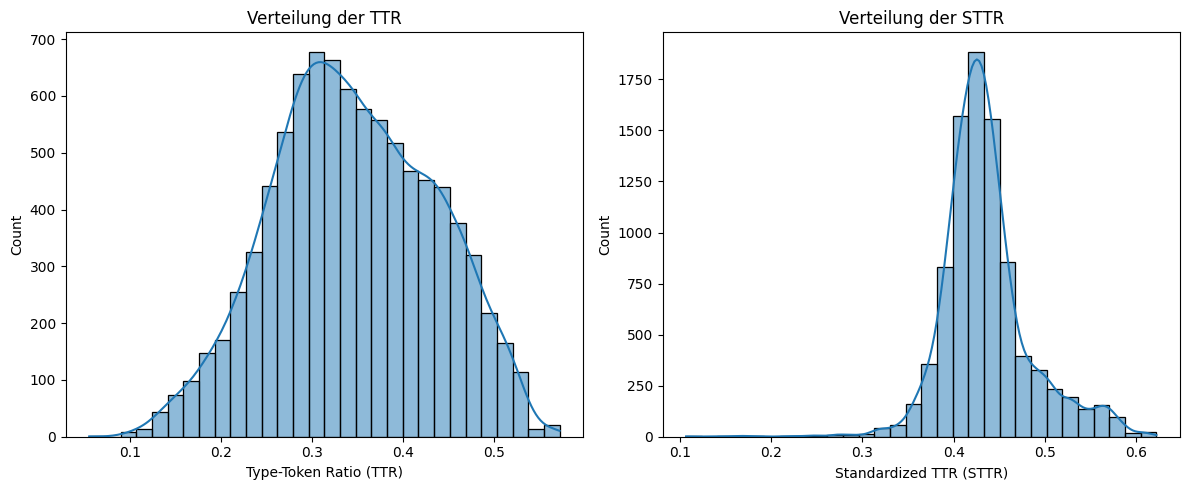

In [24]:
# Histogram for TTR and STTR
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_drop["TTR"], bins=30, kde=True, ax=axs[0])
axs[0].set_xlabel("Type-Token Ratio (TTR)")
axs[0].set_title("Verteilung der TTR")

sns.histplot(df_drop["STTR"], bins=30, kde=True, ax=axs[1])
axs[1].set_xlabel("Standardized TTR (STTR)")
axs[1].set_title("Verteilung der STTR")

plt.tight_layout()
plt.show()

### 1.2 Extract DF
Als nächstes wird der Datensatz in einen separaten Datensatz aufgeteilt, der in einem weiteren Notebook behandelt wird. Dabei werden vorerst noch die Texte besäubert und fehlende Informationen ergänzt.

In [25]:
# Text data needed to be cleaned, html in order to check/scrape manually if needed
df_nlp = df_drop[["text", "url_html"]]
# Reset indices to avoid NaN values when joining back
df_nlp.reset_index(drop=True, inplace=True)
df_nlp.head()

,text,url_html
0,BUNDESVERFASSUNGSGERICHT\n\n- 2 BvQ 1/51 -\n\n...,https://www.bundesverfassungsgericht.de/Shared...
1,Leitsätze\n\n zum ...,https://www.bundesverfassungsgericht.de/Shared...
2,Leitsätze\n\n\n zu...,https://www.bundesverfassungsgericht.de/Shared...
3,Leitsätze\n\n\...,https://www.bundesverfassungsgericht.de/Shared...
4,"BVerfGE 7,198 ff.\n...",https://www.bundesverfassungsgericht.de/Shared...


In [26]:
# First remove \n new lines and whitespace
df_nlp.loc[:, "text_clean"] = df_nlp["text"].apply(lambda x: re.sub(r'\n+', ' ', x))
df_nlp.loc[:, "text_clean"] = df_nlp["text_clean"].apply(lambda x: re.sub(r'\s+', ' ', x))

C:\Users\25mad\AppData\Local\Temp\ipykernel_31452\1178134097.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp.loc[:, "text_clean"] = df_nlp["text"].apply(lambda x: re.sub(r'\n+', ' ', x))


In [27]:
# Look at last entries
pd.set_option('display.max_colwidth', 500)
df_nlp["text_clean"].iloc[-500:]

8449    BUNDESVERFASSUNGSGERICHT - 1 BvR 618/22 - In dem Verfahren über die Verfassungsbeschwerde des Herrn (...), gegen a) die Ladung zum Termin zur mündlichen Anhörung am 21. September 2022 durch das Amtsgericht Pinneberg vom 27. Juli 2022 - 42 XVII 19503 -, b) den Beschluss des Amtsgerichts Pinneberg vom 18. Mai 2022 - 42 XVII 19503 -, c) den Beschluss des Amtsgerichts Pinneberg vom 28. April 2022 - 42 XVII 19503 -, d) den Beschluss des Landgerichts Itzehoe vom 8. März 2022 - 4 T 47/22 -, e) den ...
8450    BUNDESVERFASSUNGSGERICHT - 1 BvQ 45/22 - In dem Verfahren über den Antrag, im Wege der einstweiligen Anordnung sinngemäß: die aufschiebende Wirkung der Klage gegen die mit dem Bescheid des Landratsamts Garmisch-Partenkirchen vom 25. Juni 2022 - Az. 51-1341/ G7-Sternmarsch - verfügte Auflage Nummer A. 1. c. mit der Maßgabe wiederherzustellen, dass der Versammlungsort 200 Meter Richtung Südwesten und Schloss Elmau auf den von der Mautstraße abzweigenden Weg (Koordinaten: 47.464404,

Es fällt auf, dass insbesondere bei den letzten Texten, es offensichtlich Probleme gegeben haben muss beim Einlesen der PDFs. Aus diesen Gründen wird nachfolgend geschaut, welche Urteile davon betroffen sind, wie man diese identifizieren kann und nachträglich die Urteile korrekt einlesen kann.

In [28]:
# Identify commonly seen "VVer", "V Ver" or "VOLKES OLKES" in wrongly processed PDFs
def get_doubleV(x):
    if x is not None:
        a = re.search(r'(\bVVer\b|V\s*Ver\b|V\s*VOLKES\s*OLKES)', x)
        if a:
            return a.group()
    return -1 

In [29]:
# Mark wrongly processed texts
df_nlp.loc[:, "false_entries"] = df_nlp["text_clean"].apply(get_doubleV)

C:\Users\25mad\AppData\Local\Temp\ipykernel_31452\1001806063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nlp.loc[:, "false_entries"] = df_nlp["text_clean"].apply(get_doubleV)


In [30]:
df_nlp[df_nlp["false_entries"] != -1].shape

(390, 4)

Es existieren um die 400 Einträge, in welchen entweder ein doppeltes VV, ein "V Ver" oder ein "VOLKES OLKES" existiert. All diese Zeichenfolgen sind beim Durchgehen des Datensatzes auffällig gewesen, besonders da sie am Anfang eines fehlerhaften Textes vorzufinden waren. Diese Einträge werden in einen separaten Datensatz behandelt.

In [31]:
# Separate dfs from each other
df_nlp_clean = df_nlp.loc[df_nlp["false_entries"] == -1, :]
df_false = df_nlp[df_nlp["false_entries"] != -1]

Der getrennte Datensatz scheint soweit keinen Fehler weiter zu enthalten. Für die fehlerhaften Einträge werden nachfolgend nocheinmal die HTML URLs aufgerufen und der Text neu-gescrapt.

In [32]:
import requests
from bs4 import BeautifulSoup
import os
import json

def fetch_html_text(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    content_div = soup.find("div", class_="content")
    if content_div:
        text = content_div.get_text(separator="\n", strip=True)
    else:
        print("No content found")
    
    discard = ["PDF-Download", "Top-Links", "Pressemitteilung"]
    for phrase in discard:
        text = text.replace(phrase, '')
    
    return text


# Either load the data if file is available or run the script once
def load_or_fetch_data(df):
    file_path = "newly_fetched_texts"
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            cached_data = json.load(f)
    else:
        cached_data = {}
    
    for url in df["url_html"]:
        if url not in cached_data:
            cached_data[url] = fetch_html_text(url)
    
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(cached_data, f, ensure_ascii=False, indent=4)
    
    df["text_new"] = df["url_html"].map(lambda url: cached_data.get(url, ""))
    
    return df


In [33]:
df_false = load_or_fetch_data(df_false)

C:\Users\25mad\AppData\Local\Temp\ipykernel_31452\3832453859.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_new"] = df["url_html"].map(lambda url: cached_data.get(url, ""))


In [34]:
df_false.head(1)

,text,url_html,text_clean,false_entries,text_new
1576,BUNDES\nBUNDESVERF\n VERFASSUNGSGERICHT\n ASSUNGSGERICHT\n\n- 2 BvR 1252/99 -\n\n- 2 BvR 1253/99 -\n\n- 2 BvR 1254/99 -\n\n- 2 BvR 1255/99 -\n\n- 2 BvR 1256/99 -\n\n- 2 BvR 1257/99 -\n\n In den VVer\n erfahr\n fahren\n en\n über\n die V\n...,https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2001/07/rk20010718_2bvr125299.html,"BUNDES BUNDESVERF VERFASSUNGSGERICHT ASSUNGSGERICHT - 2 BvR 1252/99 - - 2 BvR 1253/99 - - 2 BvR 1254/99 - - 2 BvR 1255/99 - - 2 BvR 1256/99 - - 2 BvR 1257/99 - In den VVer erfahr fahren en über die V Ver erfassungsbesch fassungsbeschwer werden den 1. des Herrn Axel H e i m e n d a h l , Randstraße 118, 47804 Krefeld, - 2 BvR 1252/99 -, 2. des Herrn Elmar E r l e m a n n , Friedrich-Ebert-Straße 333, 47800 Krefeld, - 2 BvR 1253/99 -, 3. des Herrn Josef S t a n g e n b e r g , Vulkanstraße 49,...",VVer,"Beschluss vom 18. Juli 2001\n\n - Nr. 79/2001 vom 26. Juli 2001\nBUNDESVERFASSUNGSGERICHT\n- 2 BvR 1252/99 -\n- 2 BvR 1253/99 -\n- 2 BvR 1254/99 -\n- 2 BvR 1255/99 -\n- 2 BvR 1256/99 -\n- 2 BvR 1257/99 -\nIn den Verfahren\nüber\ndie Verfassungsbeschwerden\n1. des Herrn H.\n- 2 BvR 1252/99 -,\n2. des Herrn E.\n- 2 BvR 1253/99 -,\n3. des Herrn Josef S.\n- 2 BvR 1254/99 -,\n4. des Herrn Prof. Dr.-Ing.\n- 2 BvR 1255/99 -,\n5. des Herrn Franz-Josef G.\n- 2 BvR 1256/99 -,\n6. des Herrn Willi W.\..."


In [35]:
# Remove \n new lines and "Beschluss vom...": anything after Bundesverfassungsgericht remains
no_matches = []
def clean_newtext(row):
    match = re.search(r"BUNDESVERFASSUNGSGERICHT", row, re.IGNORECASE)
    if match:
        row = row[match.start():]  
    else:
        no_matches.append(row) 
    return row

In [36]:
print("No matches in:", len(no_matches), "cases")

No matches in: 0 cases


Es gibt 6 Einträge, bei welchem die HTTP Request fehlschlägt und bei manuellem Aufrufen der hinterlegten URL, derselbe 404 Fehler erscheint. Bei diesen Einträgen lässt es sich nicht vermeiden mit dem fehlerhaften, orignell eingelesenem Text weiterzuarbeiten. 

In [37]:
df_false.loc[:, "text_clean"] = df_false["text_new"].apply(clean_newtext)
# if there was no match (HTTP-Request failed), add the text from the origial
df_false.loc[:, "text_clean"][df_false["text_clean"].str.contains("HTTP Status 404", na=False)] = df_false["text"]

C:\Users\25mad\AppData\Local\Temp\ipykernel_31452\3061065758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_false.loc[:, "text_clean"][df_false["text_clean"].str.contains("HTTP Status 404", na=False)] = df_false["text"]


In [38]:
df_false["text_clean"].str.contains("HTTP Status 404", na=False).shape

(390,)

In [39]:
# Remove new lines and whitespaces 
df_false.loc[:, "text_clean"] = df_false["text_clean"].apply(lambda x: re.sub(r'\n+', ' ', x))
df_false.loc[:, "text_clean"] = df_false["text_clean"].apply(lambda x: re.sub(r'\s+', ' ', x))

In [40]:
df_nlp_final = pd.concat([df_false, df_nlp_clean], ignore_index=True)
df_nlp_final = df_nlp_final.drop(["text_new", "false_entries"], axis=1)

In [41]:
df_nlp_final.head(2)

,text,url_html,text_clean
0,BUNDES\nBUNDESVERF\n VERFASSUNGSGERICHT\n ASSUNGSGERICHT\n\n- 2 BvR 1252/99 -\n\n- 2 BvR 1253/99 -\n\n- 2 BvR 1254/99 -\n\n- 2 BvR 1255/99 -\n\n- 2 BvR 1256/99 -\n\n- 2 BvR 1257/99 -\n\n In den VVer\n erfahr\n fahren\n en\n über\n die V\n...,https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2001/07/rk20010718_2bvr125299.html,"BUNDESVERFASSUNGSGERICHT - 2 BvR 1252/99 - - 2 BvR 1253/99 - - 2 BvR 1254/99 - - 2 BvR 1255/99 - - 2 BvR 1256/99 - - 2 BvR 1257/99 - In den Verfahren über die Verfassungsbeschwerden 1. des Herrn H. - 2 BvR 1252/99 -, 2. des Herrn E. - 2 BvR 1253/99 -, 3. des Herrn Josef S. - 2 BvR 1254/99 -, 4. des Herrn Prof. Dr.-Ing. - 2 BvR 1255/99 -, 5. des Herrn Franz-Josef G. - 2 BvR 1256/99 -, 6. des Herrn Willi W. - 2 BvR 1257/99 - - Bevollmächtigte: Rechtsanwälte Heinrich Deubner und Koll., Mozartst..."
1,BUNDESVERFASSUNGSGERICHT\n\n- 1 BvR 189/09 -\n\n In dem VVer\n erfahr\n fahren\n en\n über\n die V\n Ver\n erfassungsbesch\n fassungsbeschwer\n ...,https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2009/02/rk20090224_1bvr018909.html,"BUNDESVERFASSUNGSGERICHT - 1 BvR 189/09 - In dem Verfahren über die Verfassungsbeschwerde 1. der Frau W…, 2. des Herrn H…, 3. des H…, - Bevollmächtigte: Rechtsanwälte Wurster Wirsing Schotten, Kaiser-Joseph-Straße 247, 79098 Freiburg - gegen a) den Beschluss des Hessischen Verwaltungsgerichtshofs vom 22. Dezember 2008 - 11 C 338/08.T -, - hinsichtlich des Beschwerdeführers zu 2) - b) den Beschluss des Hessischen Verwaltungsgerichtshofs vom 22. Dezember 2008 - 11 B 358/08.T -, - hinsichtlich ..."


In [42]:
df_nlp_final.isna().sum()

text          0
url_html      0
text_clean    0
dtype: int64

In [43]:
# Remove the first Sentences (Bundesverfassungsgericht ... im Namen des Volkes... im Verfahren über...)
# Remove anything before the "über "
df_nlp_final["text_clean"] = df_nlp_final["text_clean"].apply(lambda x: x.split("über ", 1)[-1])
# Remove the ECLI information
df_nlp_final["text_clean"] = df_nlp_final["text_clean"].apply(lambda x: x.split("European Case Law Identifier (ECLI): ")[0])
# Remove Zitiervorschlag information
df_nlp_final["text_clean"] = df_nlp_final["text_clean"].apply(lambda x: x.split("Zitiervorschlag ")[0])

In [44]:
df_nlp_final.head(2)

,text,url_html,text_clean
0,BUNDES\nBUNDESVERF\n VERFASSUNGSGERICHT\n ASSUNGSGERICHT\n\n- 2 BvR 1252/99 -\n\n- 2 BvR 1253/99 -\n\n- 2 BvR 1254/99 -\n\n- 2 BvR 1255/99 -\n\n- 2 BvR 1256/99 -\n\n- 2 BvR 1257/99 -\n\n In den VVer\n erfahr\n fahren\n en\n über\n die V\n...,https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2001/07/rk20010718_2bvr125299.html,"die Verfassungsbeschwerden 1. des Herrn H. - 2 BvR 1252/99 -, 2. des Herrn E. - 2 BvR 1253/99 -, 3. des Herrn Josef S. - 2 BvR 1254/99 -, 4. des Herrn Prof. Dr.-Ing. - 2 BvR 1255/99 -, 5. des Herrn Franz-Josef G. - 2 BvR 1256/99 -, 6. des Herrn Willi W. - 2 BvR 1257/99 - - Bevollmächtigte: Rechtsanwälte Heinrich Deubner und Koll., Mozartstraße 13, 76133 Karlsruhe - gegen Artikel 1 des Gesetzes zur Neueinteilung der Wahlkreise für die Wahl zum Deutschen Bundestag vom Juli 1998 (BGBl I S. 1698..."
1,BUNDESVERFASSUNGSGERICHT\n\n- 1 BvR 189/09 -\n\n In dem VVer\n erfahr\n fahren\n en\n über\n die V\n Ver\n erfassungsbesch\n fassungsbeschwer\n ...,https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2009/02/rk20090224_1bvr018909.html,"die Verfassungsbeschwerde 1. der Frau W…, 2. des Herrn H…, 3. des H…, - Bevollmächtigte: Rechtsanwälte Wurster Wirsing Schotten, Kaiser-Joseph-Straße 247, 79098 Freiburg - gegen a) den Beschluss des Hessischen Verwaltungsgerichtshofs vom 22. Dezember 2008 - 11 C 338/08.T -, - hinsichtlich des Beschwerdeführers zu 2) - b) den Beschluss des Hessischen Verwaltungsgerichtshofs vom 22. Dezember 2008 - 11 B 358/08.T -, - hinsichtlich der Beschwerdeführerin zu 1) - c) den Beschluss des Hessischen V..."


In [85]:
df[df["eingangsnummer"] == 1436 ]

,doc_id,text,url_html,url_pdf,gericht,datum,entscheidungsjahr,entscheidung_typ,spruchkoerper_typ,spruchkoerper_az,...,richter_7,richter_8,richter_9,richter_10,richter_11,richter_12,richter_13,richter_14,richter_15,richter_16
2417,BVerfG_2003-09-24_S_2_BvR_1436_02_NA_Kopftuch-1_108_282.txt,"Leitsätze\n zum Urteil des Zweiten Senats vom 24. September 2003\n - 2 BvR 1436/02 -\n\n1. Ein Verbot für Lehrkräfte, in Schule und Unterricht ein Kopftuch zu tragen, findet im geltenden Recht des Landes Baden-Württemberg keine\n hinreichend bestimmte gesetzliche Grundlage.\n2. Der mit zunehmender religiöser Pluralität verbundene gesellschaftliche Wandel kann für den Gesetzgeber Anlass zu einer Neubestimmung des zulässigen Ausmaße...",https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2003/09/rs20030924_2bvr143602.html,https://www.bundesverfassungsgericht.de/SharedDocs/Downloads/DE/2003/09/rs20030924_2bvr143602.pdf?__blob=publicationFile&v=1,BVerfG,2003-09-24,2003,U,S,2.0,...,Mellinghoff,Lübbe-Wolff,Di Fabio,None,None,None,None,None,None,None
2598,BVerfG_2004-03-15_S_2_BvR_1436_02_NA_NA_NA_NA.txt,"BUNDESVERFASSUNGSGERICHT\n- 2 BVR 1436/02 -\n\n\n\n\n In dem Verfahren\n über\n die Verfassungsbeschwerde\nder Frau L...,\n\n- Bevollmächtigte: Rechtsanwälte Dr. Hellmut Nonnenmacher und Koll.,\n Wendtstraße 17, 76185 Karlsruhe -\ngegen a) das Urteil des Bundesverwaltungsgerichts vom 4. Juli 2002\n - BVerwG 2 C 21.01 -,\n\n b) das Urteil des Verwaltungsgerichtshofs...",https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2004/03/rs20040315_2bvr143602.html,https://www.bundesverfassungsgericht.de/SharedDocs/Downloads/DE/2004/03/rs20040315_2bvr143602.pdf?__blob=publicationFile&v=1,BVerfG,2004-03-15,2004,B,S,2.0,...,Lübbe-Woff,Gerhardt,None,None,None,None,None,None,None,None
6725,BVerfG_2017-09-11_K_1_BvR_1436_17_NA_NA_NA_NA.txt,"BUNDESVERFASSUNGSGERICHT\n\n- 1 BvR 1436/17 -\n\n In dem Verfahren\n über\n die Verfassungsbeschwerde\n\nder Frau H…,\n\n- Bevollmächtigter: S…, LL.M.,\n\n\ngegen a) den Beschluss des Bundesgerichtshofs vom 7. März 2017 - XI ZR 444/\n 16 -,\n\n b) das Urteil des Oberlandesgerichts Frankfurt am Main vom 19. Juli 2016\n - 10 U 137/15 -,\n\n c) das Urteil des Landgerichts ...",https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2017/09/rk20170911_1bvr143617.html,https://www.bundesverfassungsgericht.de/SharedDocs/Downloads/DE/2017/09/rk20170911_1bvr143617.pdf?__blob=publicationFile&v=1,BVerfG,2017-09-11,2017,B,K,1.0,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
registerzeichen = df["registerzeichen"].unique()

def clean_text_chars(text):
    # Remove anythin between dashes
    text = re.sub(r'-[^-]+-', '', text)
    # Remove optional number + registerzeichen + number/number
    text = re.sub(r'\b\d*\s*registerzeichen\s*\d+/\d+\b', '', text)
    # Remove anything in parentheses; old cases
    text = re.sub(r'\(.*?\)', ' ', text)  
    # Whitespaces
    text = re.sub(r"\s+", " ", text)
    return text

In [46]:
df_nlp_final['text_clean2'] = df_nlp_final['text_clean'].apply(clean_text_chars)

In [47]:
df_nlp_final['text_clean2'].iloc[300]

'die Verfassungsbeschwerde des Herrn , gegen a) den Beschluss des Schleswig 1 Ws 34/23 H 40 Gs 1205/21 Holsteinischen Oberlandesgerichts im ersten Haftprüfungstermin. I. 2 1. Der 37Chat“Holsteinische Oberlandesgericht auf Antrag der Generalstaatsanwaltschaft die Fortdauer der Untersuchungshaft an. Die Haftfortdauer über sechs Monate hinaus sei aus wichtigem Grund gerechtfertigt und auch nicht unverhältnismäßig. Zur Begründung schloss sich das Oberlandesgericht den Ausführungen der Generalstaatsanwaltschaft an: Es sei der bei der Jahresgeschäftsverteilung 2023 nicht vorhersehbaren ungewöhnlich hohen Belastung der Kammer geschuldet, dass der Beginn der Hauptverhandlung erst ab dem 23. Januar 2024 vorgesehen sei. Die Kammer verhandele derzeit zwei umfangreiche Schwurgerichtsverfahren mit 77 beziehungsweise 127 in den Anklagen benannten Zeugen, weshalb Hauptverhandlungstermine nicht mehr zur Verfügung stünden. Bis Jahresende müsse die Kammer eine weitere, bereits länger eingegangene Haftsa

In [48]:
# Removes dates, often given in form "dd. Month YYYY"
def remove_dates(text):
    text = re.sub(r'\b\d{1,2}\.\s?(Januar|Februar|März|April|Mai|Juni|Juli|August|September|Oktober|November|Dezember)\s?\d{2,4}\b', '', text)
    text = re.sub(r"\s+", " ", text)
    return text

In [49]:
df_nlp_final['text_clean2'] = df_nlp_final['text_clean2'].apply(remove_dates)

In [50]:
# Get all possible Gesetzesbücher from which are quoted
gesetzes_abkuerzungen = [
    "GG", "BGB", "HGB", "InsO", "WEG", "BMG", 
    "EStG" ,"AO" ,"UStG", "KStG", "GewStG" ,
    "StVO" ,"FZV", "FeV", "StVG" ,"BKatV" ,"StVZO" ,
    "AufenthG" ,"AsylG" ,"AufenthV", "BeschV", "IntV" ,
    "BImSchG", "BNatSchG", "WHG", "TierSchG",
"StGB", "StPO" ,"EGStPO", "JGG", "IRG",
"ZPO", "EGZPO", "FamFG", "ZVG",
"GVG", "SGG" ,"ArbGG", "VwGO" ,"BVerfGG" ,"VwVfG",
"RVG", "GKG", "FamGKG" ,"GNotKG" ,"JVEG",
"BRAO", "BNotO" ,"RDG", "DRiG", "PAO" ,"RPflG", 
# Added
"BWahlG", "AsylbLG", "HmbPolDVG", "Bundesverfassungsgerichtsgesetz", "WRV"]

gesetzes_abkuerzungen_pattern = r'\b(?:' + '|'.join(gesetzes_abkuerzungen) + r')\b'

# Extract anything starting with either "§" or "Art."
def extract_laws(text):
    pattern =r'(?:§{1,2}\s?.*?\s' + gesetzes_abkuerzungen_pattern + r')|(?:Art\.\s?.*?\s' + gesetzes_abkuerzungen_pattern + r')'
    matches = re.findall(pattern, text)
    return matches if matches else None

In [51]:
df_nlp_final['gesetzesverweise'] = df_nlp_final['text_clean2'].apply(extract_laws)

In [52]:
# After extracting laws, and quotes, we can remove any kind of number and special chars
def remove_all_special_chars(text):
    # Remove any special signs like punctuation
    text = re.sub(r'[^a-zA-Z0-9äöüßÄÖÜ\s]', '', text)
    # Remove any 1 length letters
    text = re.sub(r'\b\w\b', '', text).strip()

    # Remove any number with a letter afterwards, e.g, 93a
    text = re.sub(r'\b\d+[a-zA-Z]?\b', '', text)

    text = re.sub(r'\s+', " ", text)
    return text

In [53]:
df_nlp_final['clean_wo_numbers'] = df_nlp_final['text_clean2'].apply(remove_all_special_chars)

In [54]:
df_nlp_final[["text_clean2", "clean_wo_numbers"]].iloc[2]

text_clean2         die Verfassungsbeschwerden des Herrn M... I. gegen a) den Beschluss des Bundesgerichtshofs vom , b) das Urteil des Landgerichts Augsburg vom , c) den Beschluss des Bundesgerichtshofs vom , d) das Urteil des Landgerichts Augsburg vom , II. gegen den Beschluss des Oberlandesgerichts München vom hat die 2. Kammer des Zweiten Senats des Bundesverfassungsgerichts durch die Richter Broß, Di Fabio und Landau gemäß § 93b in Verbindung mit § 93a BVerfGG in der Fassung der Bekannt­machung vom am einst...
clean_wo_numbers    die Verfassungsbeschwerden des Herrn gegen den Beschluss des Bundesgerichtshofs vom das Urteil des Landgerichts Augsburg vom den Beschluss des Bundesgerichtshofs vom das Urteil des Landgerichts Augsburg vom II gegen den Beschluss des Oberlandesgerichts München vom hat die Kammer des Zweiten Senats des Bundesverfassungsgerichts durch die Richter Broß Di Fabio und Landau gemäß in Verbindung mit BVerfGG in der Fassung der Bekanntmachung vom am einstimmig besc

In [55]:
df_nlp_final.isna().sum()

text                   0
url_html               0
text_clean             0
text_clean2            0
gesetzesverweise    1360
clean_wo_numbers       0
dtype: int64

In [56]:
df_nlp_final[df_nlp_final["gesetzesverweise"].isna()].head(2)

,text,url_html,text_clean,text_clean2,gesetzesverweise,clean_wo_numbers
17,BUNDES\nBUNDESVERF\n VERFASSUNGSGERICHT\n ASSUNGSGERICHT\n\n- 2 BvR 2216/20 -\n\n- 2 BvR 2217/20 -\n\n\n\n\n IM NAMEN DES V\n VOLKES\n OLKES\n\n In den V\n Ver\n erfahr\n fahren\n ...,https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2022/07/rs20220713_2bvr221620.html,"die Verfassungsbeschwerde 1. des Herrn (…), 2. der (…)-GmbH, vertreten durch den Geschäftsführer (…), 3. des (…)-e.V., vertreten durch den Vorstand (…), - Bevollmächtigte: (…), - gegen Artikel 1 und Artikel 3 Absatz 1 des Gesetzes zu dem Übereinkommen vom 19. Februar 2013 über ein Einheitliches Patentgericht (Beschluss des Bundestages vom 26. November 2020, Plenarprotokoll 19/195 Seite 24661 <D>, Beschluss des Bundesrates vom 18. Dezember 2020, BTDrucks 19/22847) - 2 BvR 2216/20 -, II. über ...","die Verfassungsbeschwerde 1. des Herrn , 2. der e.V., vertreten durch den Vorstand , gegen Artikel 1 und Artikel 3 Absatz 1 des Gesetzes zu dem Übereinkommen vom über ein Einheitliches Patentgericht , II. über die Verfassungsbeschwerde des Herrn Dr. Ingve Björn Stjerna, LL.M., GrafPlatz 15, 40213 Düsseldorf, gegen Artikel 1 und Artikel 3 Absatz 1 des Gesetzes zu dem Übereinkommen vom über ein Einheitliches Patentgericht hat das Bundesverfassungsgericht unter Mitwirkung der Richterinnen und R...",None,die Verfassungsbeschwerde des Herrn der eV vertreten durch den Vorstand gegen Artikel und Artikel Absatz des Gesetzes zu dem Übereinkommen vom über ein Einheitliches Patentgericht II über die Verfassungsbeschwerde des Herrn Dr Ingve Björn Stjerna LLM GrafPlatz Düsseldorf gegen Artikel und Artikel Absatz des Gesetzes zu dem Übereinkommen vom über ein Einheitliches Patentgericht hat das Bundesverfassungsgericht unter Mitwirkung der Richterinnen und Richter Vizepräsidentin König Huber Hermanns ...
28,BUNDES\nBUNDESVERF\n VERFASSUNGSGERICHT\n ASSUNGSGERICHT\n\n- 2 BvR 2189/22 -\n\nWiederholungswahl Berlin - eA\n\n\n\n\n IM NAMEN DES V\n VOLKES\n OLKES\n\n In dem VVer\n erfahr\n fahren\n e...,https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2023/01/rs20230125_2bvr218922.html,"die Verfassungsbeschwerde des Herrn (...) sowie 41 weiterer Beschwerdeführerinnen und Beschwerdeführer, - Bevollmächtigte: Rechtsanwälte Redeker Sellner Dahs Partnerschaftsgesellschaft mbB Leipziger Platz 3, 10117 Berlin - gegen das Urteil des Verfassungsgerichtshofs des Landes Berlin vom 16. November 2022 - VerfGH 154/21, VerfGH 156/21, VerfGH 171/21 und VerfGH 172/21 - hier: Antrag auf Erlass einer einstweiligen Anordung hat das Bundesverfassungsgericht - Zweiter Senat - unter Mitwirkung d...","die Verfassungsbeschwerde des Herrn sowie 41 weiterer Beschwerdeführerinnen und Beschwerdeführer, gegen das Urteil des Verfassungsgerichtshofs des Landes Berlin vom hier: Antrag auf Erlass einer einstweiligen Anordung hat das Bundesverfassungsgericht unter Mitwirkung der Richterinnen und Richter Vizepräsidentin König, Müller, KessalWulf Langenfeld Wallrabenstein Fetzer Offenloch",None,die Verfassungsbeschwerde des Herrn sowie weiterer Beschwerdeführerinnen und Beschwerdeführer gegen das Urteil des Verfassungsgerichtshofs des Landes Berlin vom hier Antrag auf Erlass einer einstweiligen Anordung hat das Bundesverfassungsgericht unter Mitwirkung der Richterinnen und Richter Vizepräsidentin König Müller KessalWulf Langenfeld Wallrabenstein Fetzer Offenloch


In [57]:
df_nlp_finalV = df_nlp_final.drop(["text_clean"], axis=1)
df_nlp_finalV = df_nlp_finalV.rename(columns={"text_clean2": "clean_w_numbers"})
df_nlp_finalV.head(2)

,text,url_html,clean_w_numbers,gesetzesverweise,clean_wo_numbers
0,BUNDES\nBUNDESVERF\n VERFASSUNGSGERICHT\n ASSUNGSGERICHT\n\n- 2 BvR 1252/99 -\n\n- 2 BvR 1253/99 -\n\n- 2 BvR 1254/99 -\n\n- 2 BvR 1255/99 -\n\n- 2 BvR 1256/99 -\n\n- 2 BvR 1257/99 -\n\n In den VVer\n erfahr\n fahren\n en\n über\n die V\n...,https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2001/07/rk20010718_2bvr125299.html,"die Verfassungsbeschwerden 1. des Herrn H. , 2. des Herrn E. , 3. des Herrn Josef S. , 4. des Herrn Prof. Dr. 2 BvR 1255/99 Josef G. , 6. des Herrn Willi W. gegen Artikel 1 des Gesetzes zur Neueinteilung der Wahlkreise für die Wahl zum Deutschen Bundestag vom Juli 1998 in Verbindung mit der Anlage zu § 2 Absatz 2 des Bundeswahlgesetzes, als danach der bisherige Wahlkreis 79 in die Wahlkreise 111 aufgeteilt wird hat die 4. Kammer des Zweiten Senats des Bundesverfassungs­gerichts durch die Ric...","[§ 2 Absatz 2 des Bundeswahlgesetzes, als danach der bisherige Wahlkreis 79 in die Wahlkreise 111 aufgeteilt wird hat die 4. Kammer des Zweiten Senats des Bundesverfassungs­gerichts durch die Richterin Präsidentin Limbach und die Richter Jentsch, Di Fabio gemäß § 93b in Verbindung mit § 93a BVerfGG, Art. 38 Abs. 1 Satz 1 GG, § 93a Abs. 2 BVerfGG, §§ 92, 23 Abs. 1 Satz 2 BVerfGG, § 21 Abs. 1 BWahlG, Art. 38 Abs. 1 GG, Art. 3 Abs. 1 GG, Art. 38 Abs. 1 Satz 1 GG, § 3 Abs. 1 BWahlG, § 3 Abs. 1 B...",die Verfassungsbeschwerden des Herrn des Herrn des Herrn Josef des Herrn Prof Dr BvR Josef des Herrn Willi gegen Artikel des Gesetzes zur Neueinteilung der Wahlkreise für die Wahl zum Deutschen Bundestag vom Juli in Verbindung mit der Anlage zu Absatz des Bundeswahlgesetzes als danach der bisherige Wahlkreis in die Wahlkreise aufgeteilt wird hat die Kammer des Zweiten Senats des Bundesverfassungsgerichts durch die Richterin Präsidentin Limbach und die Richter Jentsch Di Fabio gemäß in Verbin...
1,BUNDESVERFASSUNGSGERICHT\n\n- 1 BvR 189/09 -\n\n In dem VVer\n erfahr\n fahren\n en\n über\n die V\n Ver\n erfassungsbesch\n fassungsbeschwer\n ...,https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2009/02/rk20090224_1bvr018909.html,"die Verfassungsbeschwerde 1. der Frau W…, 2. des Herrn H…, 3. des H…, Joseph gegen a) den Beschluss des Hessischen Verwaltungsgerichtshofs vom , b) den Beschluss des Hessischen Verwaltungsgerichtshofs vom , c) den Beschluss des Hessischen Verwaltungsgerichtshofs vom , d) den Beschluss des Hessischen Verwaltungsgerichtshofs vom hat die 3. Kammer des Ersten Senats des Bundesverfassungsgerichts durch den Präsidenten Papier und die Richter Bryde, Schluckebier gemäß § 93b in Verbindung mit § 93a ...","[§ 93b in Verbindung mit § 93a BVerfGG, § 80 Abs. 5 VwGO, Art. 103 Abs. 1 und des Rechts auf den gesetzlichen Richter aus Art. 101 Abs. 1 Satz 2 GG, § 93a Abs. 2 BVerfGG, § 90 Abs. 1 BVerfGG, Art. 103 Abs. 1 GG, Art. 103 Abs. 1 GG, Art. 103 Abs. 1 GG, Art. 103 Abs. 1 GG, Art. 103 Abs. 1 GG, Art. 103 Abs. 1 GG, Art. 103 Abs. 1 GG, Art. 103 Abs. 1 GG, Art. 103 Abs. 1 GG, § 152a Abs. 5 Satz 1 VwGO, § 21g GVG, § 321a ZPO, Art. 101 Abs. 1 Satz 2 GG, § 93d Abs. 1 Satz 3 BVerfGG]",die Verfassungsbeschwerde der Frau des Herrn des Joseph gegen den Beschluss des Hessischen Verwaltungsgerichtshofs vom den Beschluss des Hessischen Verwaltungsgerichtshofs vom den Beschluss des Hessischen Verwaltungsgerichtshofs vom den Beschluss des Hessischen Verwaltungsgerichtshofs vom hat die Kammer des Ersten Senats des Bundesverfassungsgerichts durch den Präsidenten Papier und die Richter Bryde Schluckebier gemäß in Verbindung mit BVerfGG in der Fassung der Bekanntmachung vom am einsti...


In [63]:
# Add original columns that are interesting
df_nlp_finalV2 = df_nlp_finalV.merge(df_drop[["datum", "entscheidungsjahr", "entscheidung_typ", "spruchkoerper_typ", "spruchkoerper_az", "registerzeichen", "pressemitteilung"]], left_index=True, right_index=True)
df_nlp_finalV2 = df_nlp_finalV2.merge(df[["richter"]], left_index=True, right_index=True)

In [64]:
df_nlp_finalV2.isna().sum()

text                    0
url_html                0
clean_w_numbers         0
gesetzesverweise     1360
clean_wo_numbers        0
datum                   0
entscheidungsjahr       0
entscheidung_typ        0
spruchkoerper_typ       0
spruchkoerper_az        0
registerzeichen         0
pressemitteilung     6870
richter                24
dtype: int64

In [65]:
df_nlp_finalV2.head(1)

,text,url_html,clean_w_numbers,gesetzesverweise,clean_wo_numbers,datum,entscheidungsjahr,entscheidung_typ,spruchkoerper_typ,spruchkoerper_az,registerzeichen,pressemitteilung,richter
0,BUNDES\nBUNDESVERF\n VERFASSUNGSGERICHT\n ASSUNGSGERICHT\n\n- 2 BvR 1252/99 -\n\n- 2 BvR 1253/99 -\n\n- 2 BvR 1254/99 -\n\n- 2 BvR 1255/99 -\n\n- 2 BvR 1256/99 -\n\n- 2 BvR 1257/99 -\n\n In den VVer\n erfahr\n fahren\n en\n über\n die V\n...,https://www.bundesverfassungsgericht.de/SharedDocs/Entscheidungen/DE/2001/07/rk20010718_2bvr125299.html,"die Verfassungsbeschwerden 1. des Herrn H. , 2. des Herrn E. , 3. des Herrn Josef S. , 4. des Herrn Prof. Dr. 2 BvR 1255/99 Josef G. , 6. des Herrn Willi W. gegen Artikel 1 des Gesetzes zur Neueinteilung der Wahlkreise für die Wahl zum Deutschen Bundestag vom Juli 1998 in Verbindung mit der Anlage zu § 2 Absatz 2 des Bundeswahlgesetzes, als danach der bisherige Wahlkreis 79 in die Wahlkreise 111 aufgeteilt wird hat die 4. Kammer des Zweiten Senats des Bundesverfassungs­gerichts durch die Ric...","[§ 2 Absatz 2 des Bundeswahlgesetzes, als danach der bisherige Wahlkreis 79 in die Wahlkreise 111 aufgeteilt wird hat die 4. Kammer des Zweiten Senats des Bundesverfassungs­gerichts durch die Richterin Präsidentin Limbach und die Richter Jentsch, Di Fabio gemäß § 93b in Verbindung mit § 93a BVerfGG, Art. 38 Abs. 1 Satz 1 GG, § 93a Abs. 2 BVerfGG, §§ 92, 23 Abs. 1 Satz 2 BVerfGG, § 21 Abs. 1 BWahlG, Art. 38 Abs. 1 GG, Art. 3 Abs. 1 GG, Art. 38 Abs. 1 Satz 1 GG, § 3 Abs. 1 BWahlG, § 3 Abs. 1 B...",die Verfassungsbeschwerden des Herrn des Herrn des Herrn Josef des Herrn Prof Dr BvR Josef des Herrn Willi gegen Artikel des Gesetzes zur Neueinteilung der Wahlkreise für die Wahl zum Deutschen Bundestag vom Juli in Verbindung mit der Anlage zu Absatz des Bundeswahlgesetzes als danach der bisherige Wahlkreis in die Wahlkreise aufgeteilt wird hat die Kammer des Zweiten Senats des Bundesverfassungsgerichts durch die Richterin Präsidentin Limbach und die Richter Jentsch Di Fabio gemäß in Verbin...,1951-09-09,1951,B,S,2,BvQ,NaN,Dr. Katz|Dr. Fröhlich|Wolff|Dr. Roediger|Dr. Klaas|Henneka|Dr. Friesenhahn|Dr. Rupp|Dr. Geiger|Leuser|Dr. Federer


In [67]:
df_nlp_finalV2.columns

Index(['text', 'url_html', 'clean_w_numbers', 'gesetzesverweise',
       'clean_wo_numbers', 'datum', 'entscheidungsjahr', 'entscheidung_typ',
       'spruchkoerper_typ', 'spruchkoerper_az', 'registerzeichen',
       'pressemitteilung', 'richter'],
      dtype='object')

In [66]:
# Safe df before continueing:
df_nlp_finalV2.to_csv(r'data\df_text_clean.csv', index=False)